# Overview

In this tutorial, we train a LSTM model to predict the number of non-emergency calls in San Francisco based on the call category (e.g. <em>Tree Maintenance</em>).

In [1]:
%%capture

# Installing the required libraries:
!pip install matplotlib pandas scikit-learn
!pip install tensorflow pyarrow
!pip install google-cloud-bigquery google-cloud-bigquery-storage

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.cloud import bigquery
from sklearn import preprocessing

# Configurations
%matplotlib inline

### Configurations

Let's make sure we enter the name of our GCP project in the next cell.

In [22]:
# ENTER THE GCP PROJECT HERE
GCP_PROJECT = "YOUR-GCP-PROJECT"
print(f"GCP_PROJECT is set to {GCP_PROJECT}")

GCP_PROJECT is set to YOUR-GCP-PROJECT


In [4]:
# Just a list of few existing categories:
sample_categories = [
    "Street and Sidewalk Cleaning",
    "Encampments",
    "Litter Receptacles",
    "Tree Maintenance",
    "Sewer Issues",
    "Muni Service Feedback",
]

In [5]:
CATEGORY = sample_categories[3]
print(f"Selected category: {CATEGORY}")

Selected category: Tree Maintenance


### Authentication
The following cell authenticates the user through [Colab](https://colab.sandbox.google.com/). If you intend to run this notebook elsewhere, you will need to change the authentication code in the next cell accordingly.

In [23]:
from google.colab import auth

print("Authenticating in Colab")
auth.authenticate_user()
print("Authenticated")

Authenticating in Colab
Authenticated


### Helper Functions

Helper functions used in this notebook:

In [7]:
def prepare_data(timeseries: np.array, width: int):
    """
    Given a time series, create a matrix as the input
    for the training and a vector as the output.
    """
    data_x, data_y = [], []
    for i in range(len(timeseries) - width - 1):
        data_x.append(timeseries[i: (i + width), 0])
        data_y.append(timeseries[i + width, 0])
    return np.array(data_x), np.array(data_y)

In [8]:
def make_forecasts(model, initial_input, num_forecases=100):
    """
    Use the model to forecast the next several days.
    """
    inputs = np.array(initial_input)
    forecasts = []
    for i in range(num_forecases):
        forecast = model.predict(inputs.reshape(1, -1, 1), verbose=0)[0, 0]
        inputs = np.roll(inputs, -1)
        inputs[-1] = forecast
        forecasts.append(forecast)
    return np.array(forecasts)

## Data Preparation

### Query the Data

In [9]:
QUERY = """
WITH
  intermediate1 AS (
  SELECT
    DATE_DIFF(created_date, CURRENT_TIMESTAMP(), DAY) AS days_ago,
    category,
  FROM
    `bigquery-public-data.san_francisco_311.311_service_requests`
  WHERE
    latitude > 35
    AND longitude < -122 ),
  intermediate2 AS (
  SELECT
    DIV(days_ago - MIN(days_ago) OVER(), 7) AS week,
    category
  FROM
    intermediate1)
SELECT
  category,
  week,
  COUNT(*) AS count
FROM
  intermediate2
GROUP BY
  category,
  week;
"""

In [10]:
bqclient = bigquery.Client(project=GCP_PROJECT)
dataframe = bqclient.query(QUERY).result().to_dataframe()

### Check the Dataframe



In [11]:
print(dataframe.shape)
dataframe.head()

(27336, 3)


,category,week,count
0,Shared Spaces Violation,701,20
1,Muni Service Feedback,709,104
2,Child Request,733,51
3,Muni Service Feedback,663,59
4,Muni Employee Feedback,678,79


### Prepare the Data for Training

For the selected category above, we create a weekly time series based on number of calls that category has received in a given week:

In [12]:
category_df = dataframe[dataframe["category"] == CATEGORY]
max_week = category_df["week"].max()
min_week = category_df["week"].min()
# Some weeks may have no data, in which case we will set the value to zero.
category_timeseries = np.zeros(max_week - min_week + 1)
for index, row in category_df.iterrows():
    category_timeseries[row["week"] - min_week] = row["count"]
category_timeseries = category_timeseries.reshape(-1, 1)
print(f"Length of the time series: {len(category_timeseries)}")

Length of the time series: 737


We then normalize the time series to ensure all values are between 0 and 1.

In [13]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
nrm_timeseries = scaler.fit_transform(category_timeseries)

We split the time series into two partitions for training and testing.

In [14]:
TRAIN_RATIO = 0.7
train_size = int(len(nrm_timeseries) * TRAIN_RATIO)
test_size = len(nrm_timeseries) - train_size
train_timeseries = nrm_timeseries[0:train_size, :]

test_timeseries = nrm_timeseries[train_size: len(nrm_timeseries), :]
print(f"Training Size: {len(train_timeseries)}")
print(f"Test Size: {len(test_timeseries)}")

Training Size: 515
Test Size: 222


Next, we need to create an input matrix and an output vector from our normalized time series. Here is an example:

Let's assume we have the following variables:
```
timeseries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
width = 3
```

The matrix and the vector will then be:

```
matrix = [[0.1, 0.2, 0.3],
          [0.2, 0.3, 0.4],
          [0.3, 0.4, 0.5]]

vector = [0.4, 0.5, 0.6]
```

The `width` can help us determine how many weeks in the time series we want to look back to make a forecast about the next week.

In the example above, we want to predict a new entry by looking back at the previous 3 weeks.

Let's create the input and output for both training and test time series.

In [15]:
# Determining how far back we want to look at
# the data to make forecasts about the next entries
WEEKS_BACK = 5

train_x, train_y = prepare_data(train_timeseries, WEEKS_BACK)
test_x, test_y = prepare_data(test_timeseries, WEEKS_BACK)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((509, 5), (509,), (216, 5), (216,))

Finally, we need to reshape input with the  `[samples, features, time_steps]` dimensions where `time_steps = 1`.

In [16]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((509, 5, 1), (509,), (216, 5, 1), (216,))

## Train the Model

Now that our data is prepared, we can build and train the model. Here is a simple LSTM model.

We should not need a GPU to train this model since our training dataset is not too big.


In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, input_shape=(WEEKS_BACK, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mse", optimizer="adam")
r = model.fit(train_x, train_y, epochs=10, batch_size=16,
              validation_data=(test_x, test_y));

Epoch 1/10
32/32 [==============================] - 4s 23ms/step - loss: 0.0038 - val_loss: 0.0097
Epoch 2/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0106
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0077
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 9/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 10/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0078


Let's take a quick look at the losses for both training and test datasets:

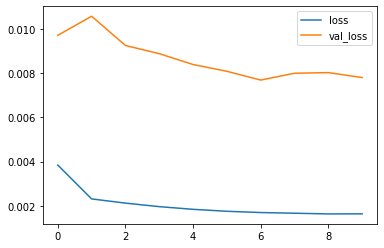

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

It is obvious that our model is overfitting and unable to fit the data properly.

## Evaluate the Model

We will use the last row in `train_x` to make several forecasts and plot the forecasts against out test data.

In [19]:
unscaled_forecasts = make_forecasts(model, train_x[-1].flatten(), len(test_y))
forecasts = scaler.inverse_transform(unscaled_forecasts.reshape(-1, 1))

To plot the results, let's first shift the forecasts to their right spot on the X-axis.

In [20]:
# shift test forecasts for plotting
test_forecasts_plot = np.empty_like(nrm_timeseries)
test_forecasts_plot[:, :] = np.nan
test_forecasts_plot[
    len(train_x) + (WEEKS_BACK * 2) + 1: len(nrm_timeseries) - 1, :
] = forecasts

Finally, we can plot the results of the forecast.

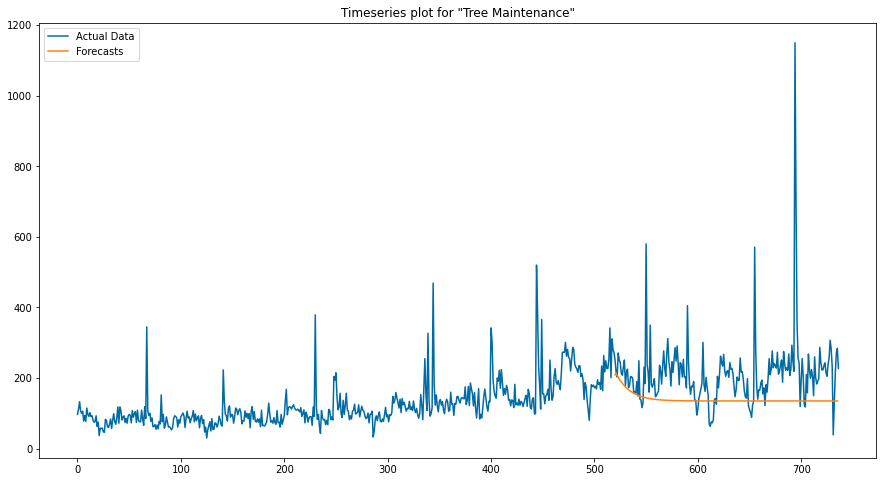

In [21]:
# plot baseline and forecasts
plt.figure(figsize=(15, 8))
plt.style.use("tableau-colorblind10")
plt.plot(category_timeseries, label="Actual Data")
plt.plot(test_forecasts_plot, label="Forecasts")
plt.legend(loc="upper left")
plt.title(f'Timeseries plot for "{CATEGORY}"')
plt.show()

The forecast results are not satisfactory. It seems the model simply copies the value from the previous week as its prdiction. None of the following strategies seem to improve the model:
- Using `SimpleRNN` or `GRU` instead of `LSTM`
- Using a larger number for `WEEKS_BACK`
- Using `GlobalMaxPooling1D` after the `LSTM` layer
- Using a different activation function such as `rele` or even `None` for the `LSTM` layer

Why is that? A look at the time series plot above hardly shows any pattern in the time series. There is barely an uptrend, and aside from some random spikes, there does not seem to be any noticable seasonality, which may be why the model underperforms.

As an exercise we invite you to try a more traditional approach, such as training an [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model instead.
